In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [15]:
#import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
import lxml

In [3]:
cd D:\Inter IIT\VOC2007

D:\Inter IIT\VOC2007


In [20]:
IMAGE_SIZE = 224
img_dir = "D:\Inter IIT\VOC2007\JPEGImages" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [21]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [22]:
path = 'D:\Inter IIT\VOC2007\Annotations'
text_files = ['D:\Inter IIT\VOC2007\Annotations/'+ f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [23]:
resizeannotation("D:\Inter IIT\VOC2007\Annotations/car_0.xml")

[194, 153, 161, 131]

In [24]:
y[0]

[194, 153, 161, 131]

In [25]:
np.array(X).shape

(669, 224, 224, 3)

In [26]:
np.array(y).shape

(669, 4)

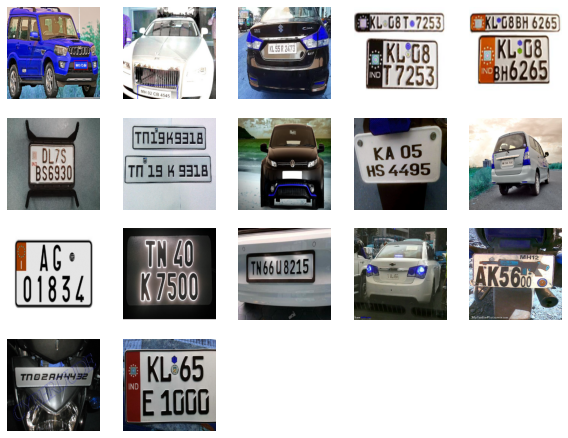

In [39]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

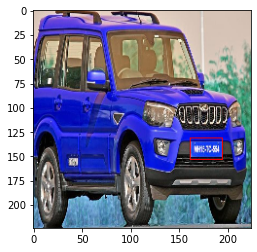

In [30]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(255, 0, 0))
plt.imshow(image)
plt.show()

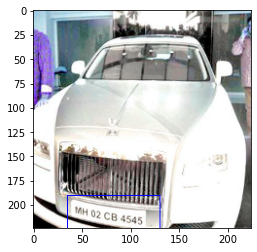

In [31]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [32]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [33]:
#Renormalisation
X = X / 255
y = y / 255

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [35]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [41]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
#model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

#model.layers[-6].trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 17,934,596
Trainable params: 17,934,596
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [43]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Train on 481 samples, validate on 54 samples
Epoch 1/50
481/481 [==============================] - 857s 2s/step - loss: 0.0539 - accuracy: 0.2994 - val_loss: 0.0226 - val_accuracy: 0.4815
Epoch 2/50
481/481 [==============================] - 473s 984ms/step - loss: 0.0227 - accuracy: 0.5322 - val_loss: 0.0216 - val_accuracy: 0.4815
Epoch 3/50
481/481 [==============================] - 391s 812ms/step - loss: 0.0254 - accuracy: 0.5156 - val_loss: 0.0222 - val_accuracy: 0.4815
Epoch 4/50
481/481 [==============================] - 371s 771ms/step - loss: 0.0220 - accuracy: 0.5489 - val_loss: 0.0224 - val_accuracy: 0.4815
Epoch 5/50
481/481 [==============================] - 370s 770ms/step - loss: 0.0220 - accuracy: 0.5177 - val_loss: 0.0215 - val_accuracy: 0.4815
Epoch 6/50
481/481 [==============================] - 365s 760ms/step - loss: 0.0214 - accuracy: 0.5177 - val_loss: 0.0214 - val_accuracy: 0.4815
Epoch 7/50
481/481 [==============================] - 360s 749ms/step - loss: 0.02

In [45]:
# Test
scores = model.evaluate(X_test, y_test)
print("Score : %.2f%%" % (scores[1]*100))


134/134 [==============================] - 22s 164ms/step
Score : 84.33%


In [46]:
 y_cnn = model.predict(X_test)


In [47]:
y_cnn.shape

(134, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

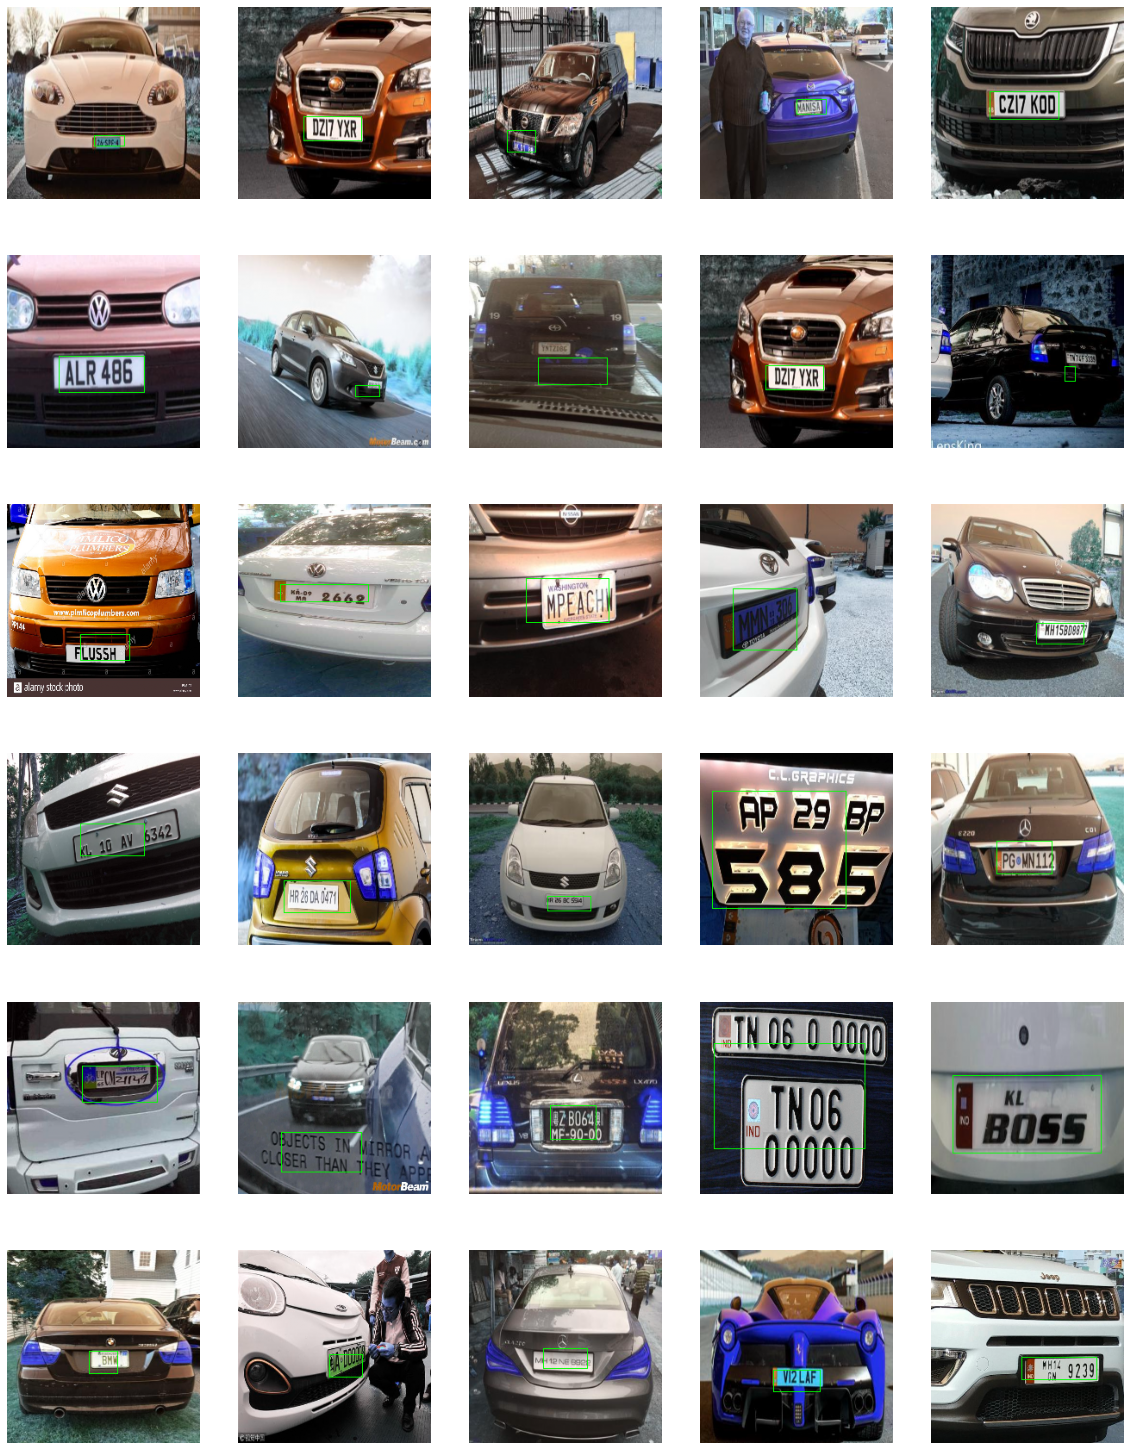

In [50]:
plt.figure(figsize=(20,45))
for i in range(0,30) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)